In [50]:
import pygrib
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from icedef import metocean

In [4]:
ds = nc.Dataset('/home/evankielley/Downloads/HYCOM_reg1_latest3d_cc9d_1cf5_5f31.nc')

In [47]:
dt64s = [np.datetime64(t) for t in nc.num2date(ds['time'][:], 
                                               'seconds since 1970-01-01T00:00:00Z', 'proleptic_gregorian')]
hycom_eastward_current_velocities = xr.DataArray(data=np.array(ds.variables['water_u'][:,0,:,:]), 
                                        coords=[('time', dt64s),
                                                ('latitude', ds.variables['latitude'][:]),
                                                ('longitude', ds.variables['longitude'][:] - 360)],
                                        attrs=None)
hycom_northward_current_velocities = xr.DataArray(data=np.array(ds.variables['water_v'][:,0,:,:]), 
                                        coords=[('time', dt64s),
                                                ('latitude', ds.variables['latitude'][:]),
                                                ('longitude', ds.variables['longitude'][:] - 360)],
                                        attrs=None)

In [58]:
ocean = metocean.ECMWFOcean((dt64s[0], dt64s[-10]))
ecmwf_eastward_current_velocities = ocean.eastward_current_velocities
ecmwf_northward_current_velocities = ocean.northward_current_velocities

In [46]:
time = np.datetime64('2015-04-20T12:00')
latitude = 50
longitude = -55
print(float(ocean.eastward_current_velocities.interp(time=time, latitude=latitude, longitude=longitude).values))
print(float(eastward_current_velocities.interp(time=time, latitude=latitude, longitude=longitude).values))

-0.0631733164191246
-0.018505151876422887


# ADCP & AVOS

In [51]:
file_loc, message = urlretrieve('http://icedef.munroelab.ca/data/StatoilArcticNet/Leg1_1501_ADCP/an1501_os150bb.nc')
adcp_ds = xr.open_dataset(file_loc)

In [52]:
avos_df = pd.read_csv('http://icedef.munroelab.ca/data/StatoilArcticNet/AVOS_2015.csv', sep=' ; ')
bad_rows = np.where((avos_df['Longitude'] > 180) | (avos_df['Longitude'] < -180) |
                    (avos_df['Latitude'] > 180) | (avos_df['Latitude'] < -180))[0]

avos_df = avos_df.drop(avos_df.index[bad_rows])
avos_df['Date'] = avos_df['Date'].str.replace('/', '-')
avos_df['Date'] = pd.to_datetime(avos_df['Date'])
avos_df['Wind speed'] = pd.to_numeric(avos_df['Wind speed'])
avos_df['Wind dir'] = pd.to_numeric(avos_df['Wind dir'])

avos_ds = avos_df.set_index('Date').to_xarray()

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [53]:
adcp_subset = adcp_ds.where((adcp_ds.lat < 60) & (adcp_ds.lat > 40) & \
                            (adcp_ds.lon < -40) & (adcp_ds.lon > -60) & \
                            (adcp_ds.u < 10) & (adcp_ds.u > -10) & \
                            (adcp_ds.v < 10) & (adcp_ds.v > -10), drop=True)

avos_subset = avos_ds.where((avos_ds['Latitude'] < 60) & (avos_ds['Latitude'] > 40) & \
                           (avos_ds['Longitude'] < -40) & (avos_ds['Longitude'] > -60), drop=True)

avos_subset = avos_subset.where(avos_subset['Date'] < adcp_subset['time'].values[-1], drop=True)

min_time = max([avos_subset['Date'].min(), adcp_ds['time'].min()]).values
max_time = min([avos_subset['Date'].max(), adcp_ds['time'].max()]).values

adcp_subset = adcp_subset.where((adcp_subset['time'] >= min_time) & (adcp_subset['time'] <= max_time), drop=True)
avos_subset = avos_subset.where((avos_subset['Date'] >= min_time) & (avos_subset['Date'] <= max_time), drop=True)

In [57]:
adcp_subset.time.values[0], adcp_subset.time.values[-1], avos_subset['Date'].values[0], avos_subset['Date'].values[-1]

(numpy.datetime64('2015-04-19T08:03:53.000000000'),
 numpy.datetime64('2015-04-30T02:58:51.000000000'),
 numpy.datetime64('2015-04-19T08:00:00.000000000'),
 numpy.datetime64('2015-04-30T03:00:00.000000000'))

# Compare By Interpolating

In [81]:
time_list = []
latitude_list = []
longitude_list = []
hycom_eastward_current_velocity_list = []
ecmwf_eastward_current_velocity_list = []
adcp_eastward_current_velocity_list = []
hycom_northward_current_velocity_list = []
ecmwf_northward_current_velocity_list = []
adcp_northward_current_velocity_list = []

for i in range(100):

    time = adcp_subset.time.values[i]
    latitude = adcp_subset.lat.values[i, 0]
    longitude = adcp_subset.lon.values[i, 0]

    try:
        hycom_eastward_current_velocity = hycom_eastward_current_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        
        ecmwf_eastward_current_velocity = ecmwf_eastward_current_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        adcp_eastward_current_velocity = adcp_subset.u[i, 0]
        
        hycom_northward_current_velocity = hycom_northward_current_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        
        ecmwf_northward_current_velocity = ecmwf_northward_current_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        adcp_northward_current_velocity = adcp_subset.v[i, 0]
        
        time_list.append(time)
        latitude_list.append(latitude)
        longitude_list.append(longitude)
        hycom_eastward_current_velocity_list.append(hycom_eastward_current_velocity)
        ecmwf_eastward_current_velocity_list.append(ecmwf_eastward_current_velocity)
        adcp_eastward_current_velocity_list.append(adcp_eastward_current_velocity)
        hycom_northward_current_velocity_list.append(hycom_northward_current_velocity)
        ecmwf_northward_current_velocity_list.append(ecmwf_northward_current_velocity)
        adcp_northward_current_velocity_list.append(adcp_northward_current_velocity)

    except KeyError:
        print(f"NaN at index {i}")
        pass

NaN at index 0
NaN at index 1
NaN at index 2
NaN at index 3
NaN at index 4
NaN at index 5
NaN at index 6
NaN at index 7
NaN at index 8
NaN at index 9
NaN at index 10
NaN at index 11
NaN at index 12
NaN at index 13
NaN at index 14
NaN at index 15
NaN at index 16
NaN at index 17
NaN at index 18
NaN at index 71
NaN at index 77
NaN at index 86
NaN at index 89
NaN at index 98


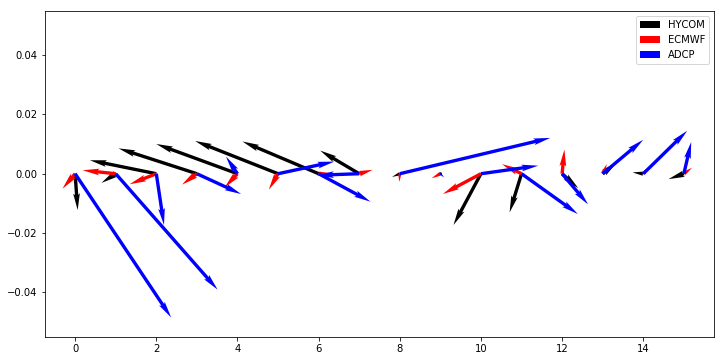

In [105]:
gap = 5
scale = 2
width = 5e-3
headwidth = 2

plt.figure(figsize=(12, 6))

plt.quiver(hycom_eastward_current_velocity_list[::gap], 
           hycom_northward_current_velocity_list[::gap], 
           scale=scale, width=width, headwidth=headwidth, color='black', label='HYCOM')

plt.quiver(ecmwf_eastward_current_velocity_list[::gap], 
           ecmwf_northward_current_velocity_list[::gap], 
           scale=scale, width=width, headwidth=headwidth, color='red', label='ECMWF')

plt.quiver(adcp_eastward_current_velocity_list[::gap], 
           adcp_northward_current_velocity_list[::gap], 
           scale=scale, width=width, headwidth=headwidth, color='blue', label='ADCP')

plt.legend()
plt.show()

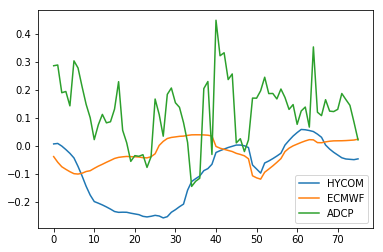

In [79]:
plt.plot(hycom_eastward_current_velocity_list, label='HYCOM')
plt.plot(ecmwf_eastward_current_velocity_list, label='ECMWF')
plt.plot(adcp_eastward_current_velocity_list, label='ADCP')
plt.legend()
plt.show()

In [70]:
adcp_subset.u

<xarray.DataArray 'u' (time: 1934, depth_cell: 30)>
array([[      nan,  0.133536,  0.126536, ...,  0.073536, -0.013464,  0.013536],
       [      nan,  0.211185,  0.141185, ...,  0.023185,  0.015185,  0.030185],
       [      nan,  0.226899,  0.187899, ..., -0.038101,  0.012899, -0.025101],
       ...,
       [      nan, -0.535595, -0.455595, ...,       nan,       nan,       nan],
       [      nan, -0.43368 , -0.39868 , ...,       nan,       nan,       nan],
       [      nan, -0.467791, -0.402791, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-04-19T08:03:53 2015-04-19T08:08:54 ...
Dimensions without coordinates: depth_cell
Attributes:
    data_max:   0.7226237
    long_name:  Zonal velocity component
    C_format:   %7.2f
    data_min:   -1.3858433
    units:      meter second-1

In [68]:
time, latitude, longitude

(numpy.datetime64('2015-04-19T08:18:55.000000000'), nan, nan)

# Old Code

In [2]:
grbs = pygrib.open('/home/evankielley/Downloads/ofs_atl.t00z.N000.20150420.3d.grb.grib2')

In [3]:
for grb in grbs[:2]:
    print(grb)

RuntimeError: b'Key/value not found'

In [4]:
grbs

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.read_csv('/home/evankielley/Downloads/eng-hourly-04012015-04302015.csv', 
                  usecols=['Date/Time', 'Wind Spd (km/h)', 'Wind Dir (10s deg)'], skiprows=15)

In [6]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Wind Dir (deg)'] = df['Wind Dir (10s deg)'] * 10
df['Wind Spd (m/s)'] = df['Wind Spd (km/h)'] * (1000 / 3600)
df['Wind Dir (rad)'] = np.deg2rad(df['Wind Dir (deg)'])
df['eastward_wind_velocity'] =  -df['Wind Spd (m/s)'] * np.sin(df['Wind Dir (rad)'])
df['northward_wind_velocity'] =  -df['Wind Spd (m/s)'] * np.cos(df['Wind Dir (rad)'])

In [7]:
df

,Date/Time,Wind Dir (10s deg),Wind Spd (km/h),Wind Dir (deg),Wind Spd (m/s),Wind Dir (rad),eastward_wind_velocity,northward_wind_velocity
0,2015-04-01 00:30:00,19,21,190,5.833,3.316,1.013,5.745
1,2015-04-01 01:30:00,22,25,220,6.944,3.840,4.464,5.320
2,2015-04-01 02:30:00,21,21,210,5.833,3.665,2.917,5.052
3,2015-04-01 03:30:00,23,37,230,10.278,4.014,7.873,6.606
4,2015-04-01 04:30:00,24,43,240,11.944,4.189,10.344,5.972
5,2015-04-01 05:30:00,25,48,250,13.333,4.363,12.529,4.560
6,2015-04-01 06:30:00,26,37,260,10.278,4.538,10.122,1.785
7,2015-04-01 07:30:00,26,37,260,10.278,4.538,10.122,1.785
8,2015-04-01 08:30:00,26,42,260,11.667,4.538,11.489,2.026
9,2015-04-01 09:30:00,25,43,250,11.944,4.363,11.224,4.085


In [8]:
start_date = np.datetime64('2015-04-19')
end_date = np.datetime64('2015-04-20')
date_bounds = start_date, end_date
atm = metocean.NARRAtmosphere(date_bounds)

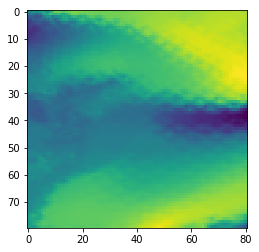

In [9]:
plt.imshow(atm.eastward_wind_velocities[0, :, :])

In [10]:
start_index = np.where(df['Date/Time'] > atm.dataset.time.values[0])[0][0]
end_index = np.where(df['Date/Time'] < atm.dataset.time.values[-1])[0][-1]

In [11]:
latitude, longitude = 47.6212, -52.7424  # St. John's International Airport

d = {'time': [], 'obs_u': [], 'obs_v': [], 'mod_u': [], 'mod_v': []}

for i in range(start_index, end_index + 1):

    time = np.datetime64(df['Date/Time'][i])
    d['time'].append(time)
    d['obs_u'].append(df['eastward_wind_velocity'][i])
    d['obs_v'].append(df['northward_wind_velocity'][i])
    d['mod_u'].append(float(atm.eastward_wind_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                         assume_sorted=True).values))
    d['mod_v'].append(float(atm.northward_wind_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                         assume_sorted=True).values))

In [12]:
d['time'][-1]

numpy.datetime64('2015-04-21T20:30:00.000000')

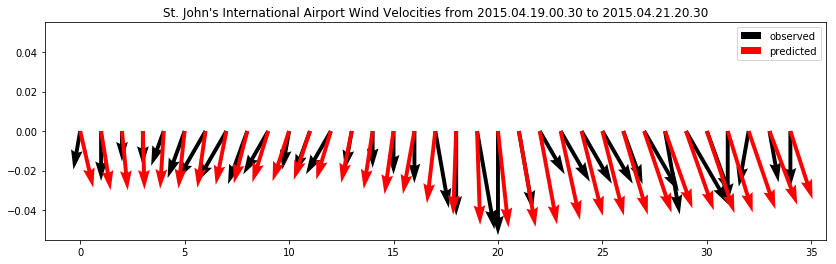

In [13]:
gap = 2
plt.figure(figsize=(14, 4))
plt.quiver(d['obs_u'][::gap], d['obs_v'][::gap], width=5e-3, scale=100, color='black', label='observed')
plt.quiver(d['mod_u'][::gap], d['mod_v'][::gap], width=5e-3, scale=100, color='red', label='predicted')
plt.title('St. John\'s International Airport Wind Velocities from {} to {}'.format(
    pd.to_datetime(str(d['time'][0])).strftime('%Y.%m.%d.%H.%M'), 
    pd.to_datetime(str(d['time'][-1])).strftime('%Y.%m.%d.%H.%M')))
plt.legend()
plt.show()